In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/Spotify_Youtube.csv')

# Plots

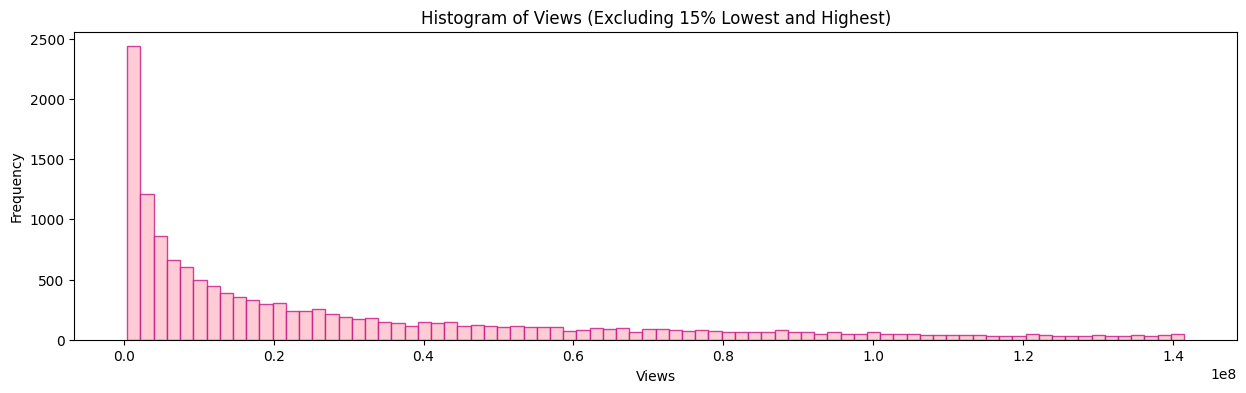

In [2]:
# Convert the 'Views' column to numeric data type
df['Views'] = pd.to_numeric(df['Views'], errors='coerce')

# Calculate the lower and upper thresholds for dropping views
lower_threshold = df['Views'].quantile(0.15)
upper_threshold = df['Views'].quantile(0.85)

# Drop rows with views outside the lower and upper thresholds
df = df[(df['Views'] >= lower_threshold) & (df['Views'] <= upper_threshold)]

# Create the histogram
plt.figure(figsize=(15, 4))
plt.hist(df['Views'], bins=80, color='pink',edgecolor='mediumvioletred', alpha=0.8)
plt.xlabel('Views')
plt.ylabel('Frequency')
plt.title('Histogram of Views (Excluding 15% Lowest and Highest)')
plt.show()

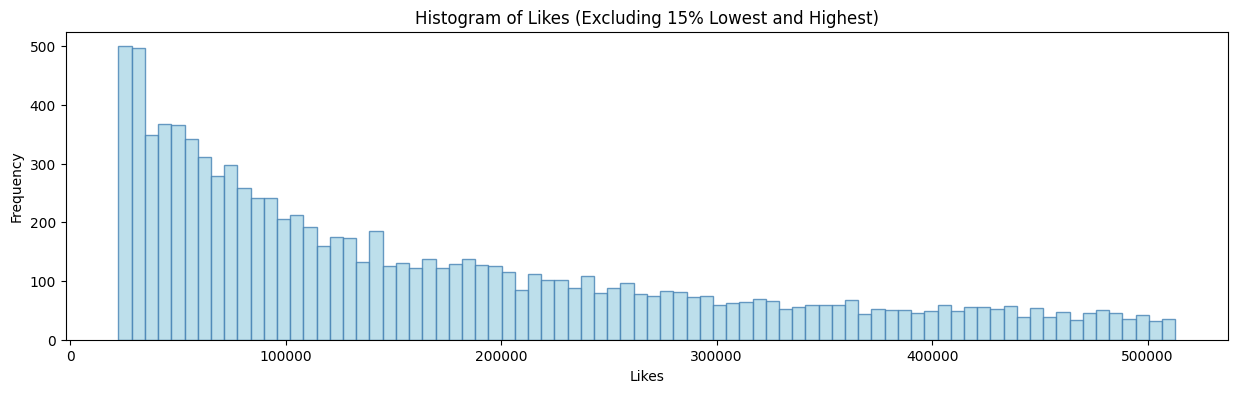

In [3]:
# Convert the 'Likes' column to numeric data type
df['Likes'] = pd.to_numeric(df['Likes'], errors='coerce')

# Calculate the lower and upper thresholds for dropping Likes
lower_threshold = df['Likes'].quantile(0.15)
upper_threshold = df['Likes'].quantile(0.85)

# Drop rows with Likes outside the lower and upper thresholds
df = df[(df['Likes'] >= lower_threshold) & (df['Likes'] <= upper_threshold)]

# Create the histogram
plt.figure(figsize=(15, 4))
plt.hist(df['Likes'], bins=80, color='lightblue',edgecolor='steelblue', alpha=0.8)
plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.title('Histogram of Likes (Excluding 15% Lowest and Highest)')
plt.show()

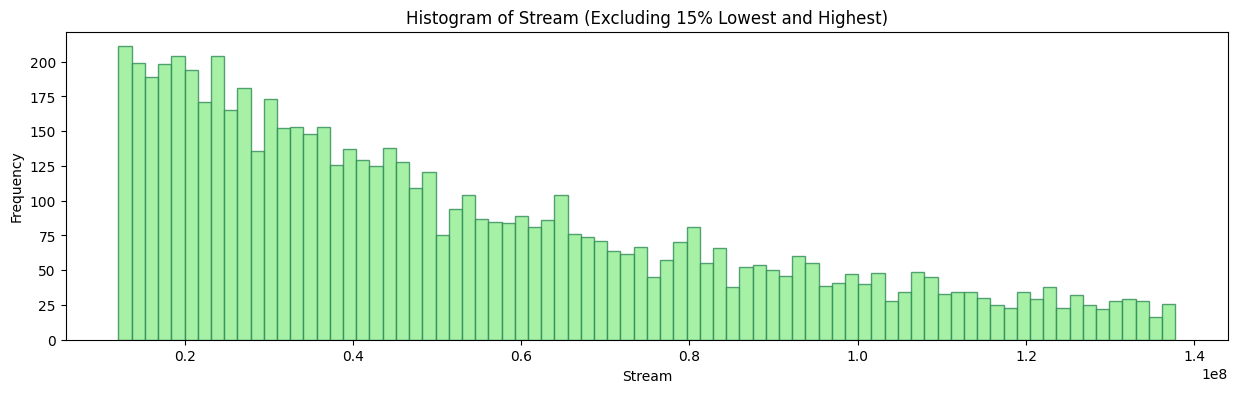

In [4]:
# Convert the 'Stream' column to numeric data type
df['Stream'] = pd.to_numeric(df['Stream'], errors='coerce')

# Calculate the lower and upper thresholds for dropping Stream
lower_threshold = df['Stream'].quantile(0.15)
upper_threshold = df['Stream'].quantile(0.85)

# Drop rows with Stream outside the lower and upper thresholds
df = df[(df['Stream'] >= lower_threshold) & (df['Stream'] <= upper_threshold)]

# Create the histogram
plt.figure(figsize=(15, 4))
plt.hist(df['Stream'], bins=80, color='lightgreen',edgecolor='seagreen', alpha=0.8)
plt.xlabel('Stream')
plt.ylabel('Frequency')
plt.title('Histogram of Stream (Excluding 15% Lowest and Highest)')
plt.show()

# Preprocess

In [5]:
columns_to_drop = ['official_video', 'Description', 'Channel',
                   'Title', 'Url_youtube', 'Uri', 'Licensed',
                   'Album', 'Track', 'Url_spotify', 'Artist',
                   'Likes', 'Stream', 'Comments',	'Unnamed: 0']  # Replace with the columns you want to drop

# Drop the specified columns
df = df.drop(columns_to_drop, axis=1)

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = df.dropna()  # Drop rows with missing values

# Separate the features (X) and target variable (y)
X = df.drop('Views', axis=1)  # Exclude the target variable column from features
y = df['Views']

# Encode categorical variables
categorical_columns = [col for col in X.columns if dict(X.dtypes)[col] == object]#['Album_type']
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

# Scale numerical variablesxc
numerical_columns = [col for col in X.columns if dict(X.dtypes)[col] == float]#['Tempo', 'Duration_ms', 'Views',....]
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])



# Feature Selection

In [7]:
from sklearn.feature_selection import f_regression

# Perform ANOVA F-value calculation using f_regression
f_values, _ = f_regression(X.fillna(0), y)  # Option 1: using f_regression

# Sort the features based on the calculated F-values
sorted_features = sorted(zip(X.columns, f_values), key=lambda x: x[1], reverse=True)

# Select the top k features
k = 10  # Number of top features to select
selected_features = [feature[0] for feature in sorted_features[:k]]

print("Selected Features:")
print(selected_features)

Selected Features:
['Loudness', 'Instrumentalness', 'Album_type', 'Speechiness', 'Valence', 'Energy', 'Liveness', 'Duration_ms', 'Danceability', 'Acousticness']


In [8]:
X[selected_features].head()

,Loudness,Instrumentalness,Album_type,Speechiness,Valence,Energy,Liveness,Duration_ms,Danceability,Acousticness
2,0.906411,0.023341,2,-0.409205,0.071936,1.361046,-0.464034,-0.092379,0.490760,-0.851447
27,0.828540,-0.261450,0,1.750397,0.517663,0.639199,-0.069448,-0.109967,1.485178,-0.746238
37,1.165981,-0.256374,2,-0.169249,-1.426205,1.719514,-0.464034,-0.145473,-1.454019,-1.006122
58,-1.769039,5.501170,0,-0.483674,-1.706849,0.202163,-0.536881,0.636678,-0.075681,0.737595
59,-0.289219,5.003241,0,-0.605721,-0.014734,0.089221,0.907912,0.391033,0.169777,-0.831424


In [9]:
y

2         8435055.0
27        5289821.0
37       14937918.0
58       23984070.0
59       30079390.0
            ...    
20677    12357927.0
20678    19551708.0
20693     8267390.0
20694     3355866.0
20695     4151807.0
Name: Views, Length: 6755, dtype: float64

# Evaluation:

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate
from tqdm import tqdm
import time


In [11]:
# Create a dictionary to store the models and hyperparameter options
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {'fit_intercept': [True, False]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [100, 200, 500], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.1, 0.5]}
    },
    'Support Vector Regression': {
        'model': SVR(),
        'params': {'C': [1, 10, 100], 'epsilon': [0.1, 0.01, 0.001]}
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsRegressor(),
        'params': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {'alpha': [0.01, 0.1, 1.0]}
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {'alpha': [0.01, 0.1, 1.0]}
    },
    'MLP': {
        'model': MLPRegressor(),
        'params': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh', 'logistic']}
    }
}



In [12]:
# Define the options for feature sets
options = {
    'Option 1': {
        'X': X,
        'features_str': 'All features'
    },
    'Option 2': {
        'X': X[selected_features],
        'features_str': 'Only selected features'
    },
}

In [13]:
# Function to run the experiment for a given option
def run_experiment(option_name, option_data, y):

    def run_grid_search(X_train, X_test, y_train, y_test, features_str, models):
        # Function to perform GridSearchCV and generate results for an option
        results = []
        train_times = []

        for model_name, model_data in tqdm(models.items(), desc="Running GridSearchCV"):
            model = model_data['model']
            params = model_data['params']
            print(f"Model name: {model_name}, params: {params}")
            grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error')

            start_time = time.time()
            grid_search.fit(X_train, y_train)
            train_time = time.time() - start_time

            best_params = grid_search.best_params_
            best_model = grid_search.best_estimator_

            y_pred = best_model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)

            results.append({
                'Model': model_name,
                'Features': features_str,
                'Best Params': best_params,
                'MSE': mse,
                'Model Object': best_model
            })
            train_times.append(train_time)

        results.sort(key=lambda x: x['MSE'])
        return results, train_times

    features_str = option_data['features_str']
    X = option_data['X']
    y = y

    #split to train/test sets 80/20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    results, train_times = run_grid_search(X_train, X_test, y_train, y_test, features_str, models)

    # Generate tables for the experiment sets
    print("Experiment Sets:")
    print("--------------------")

    headers = ['Option', 'Model', 'Features', 'Best Params', 'MSE', 'Train Time']
    rows = [[option_name, result['Model'], result['Features'], result['Best Params'], result['MSE'], train_time] for result, train_time in zip(results, train_times)]

    print(tabulate(rows, headers=headers, tablefmt="pretty"))
    print("\n")




In [14]:
# Run the experiment for each option
for option_name, option_data in options.items():
    print(f"Running Experiment for {option_name}")
    print("-----------------------------------")

    run_experiment(option_name, option_data, y)

Running Experiment for Option 1
-----------------------------------


Running GridSearchCV:   0%|          | 0/9 [00:00<?, ?it/s]

Model name: Linear Regression, params: {'fit_intercept': [True, False]}


Running GridSearchCV:  11%|█         | 1/9 [00:00<00:02,  3.10it/s]

Model name: Decision Tree, params: {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}


Running GridSearchCV:  22%|██▏       | 2/9 [00:07<00:29,  4.22s/it]

Model name: Random Forest, params: {'n_estimators': [100, 200, 500], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}


Running GridSearchCV:  33%|███▎      | 3/9 [25:43<1:10:22, 703.83s/it]

Model name: Gradient Boosting, params: {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.1, 0.5]}


Running GridSearchCV:  44%|████▍     | 4/9 [28:59<41:55, 503.19s/it]  

Model name: Support Vector Regression, params: {'C': [1, 10, 100], 'epsilon': [0.1, 0.01, 0.001]}


Running GridSearchCV:  56%|█████▌    | 5/9 [30:08<23:06, 346.68s/it]

Model name: K-Nearest Neighbors, params: {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}


Running GridSearchCV:  67%|██████▋   | 6/9 [30:12<11:30, 230.18s/it]

Model name: Lasso Regression, params: {'alpha': [0.01, 0.1, 1.0]}


Running GridSearchCV:  78%|███████▊  | 7/9 [30:12<05:10, 155.02s/it]

Model name: Ridge Regression, params: {'alpha': [0.01, 0.1, 1.0]}


Running GridSearchCV:  89%|████████▉ | 8/9 [30:13<01:45, 105.80s/it]

Model name: MLP, params: {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh', 'logistic']}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Experiment Sets:
--------------------
+----------+---------------------------+--------------+----------------------------------------------------------------+--------------------+---------------------+
|  Option  |           Model           |   Features   |                          Best Params                           |        MSE         |     Train Time      |
+----------+---------------------------+--------------+----------------------------------------------------------------+--------------------+---------------------+
| Option 1 |       Random Forest       | All features | {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500} | 562241167954171.6  | 0.31641101837158203 |
| Option 1 |     Gradient Boosting     | All features |          {'learning_rate': 0.01, 'n_estimators': 500}          | 570380727924731.1  |  6.935116291046143  |
| Option 1 |     Linear Regression     | All features |                    {'fit_intercept': True}                     | 593749320936815.2  | 

Running GridSearchCV:   0%|          | 0/9 [00:00<?, ?it/s]

Model name: Linear Regression, params: {'fit_intercept': [True, False]}


Running GridSearchCV:  11%|█         | 1/9 [00:00<00:03,  2.42it/s]

Model name: Decision Tree, params: {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}


Running GridSearchCV:  22%|██▏       | 2/9 [00:02<00:11,  1.64s/it]

Model name: Random Forest, params: {'n_estimators': [100, 200, 500], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}


Running GridSearchCV:  33%|███▎      | 3/9 [21:21<58:28, 584.71s/it]

Model name: Gradient Boosting, params: {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.1, 0.5]}


Running GridSearchCV:  44%|████▍     | 4/9 [24:08<34:59, 419.85s/it]

Model name: Support Vector Regression, params: {'C': [1, 10, 100], 'epsilon': [0.1, 0.01, 0.001]}


Running GridSearchCV:  56%|█████▌    | 5/9 [25:13<19:27, 291.96s/it]

Model name: K-Nearest Neighbors, params: {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}


Running GridSearchCV:  78%|███████▊  | 7/9 [25:17<04:21, 130.65s/it]

Model name: Lasso Regression, params: {'alpha': [0.01, 0.1, 1.0]}
Model name: Ridge Regression, params: {'alpha': [0.01, 0.1, 1.0]}


Running GridSearchCV:  89%|████████▉ | 8/9 [25:18<01:29, 89.11s/it] 

Model name: MLP, params: {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh', 'logistic']}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Experiment Sets:
--------------------
+----------+---------------------------+------------------------+----------------------------------------------------------------+--------------------+---------------------+
|  Option  |           Model           |        Features        |                          Best Params                           |        MSE         |     Train Time      |
+----------+---------------------------+------------------------+----------------------------------------------------------------+--------------------+---------------------+
| Option 2 |       Random Forest       | Only selected features | {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500} | 563753470349842.8  | 0.4063260555267334  |
| Option 2 |     Gradient Boosting     | Only selected features |          {'learning_rate': 0.01, 'n_estimators': 500}          | 569877369296487.0  | 2.4931137561798096  |
| Option 2 |     Linear Regression     | Only selected features |                    {'fit_i